In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import roc_curve, auc as calc_auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [3]:
Dataset = pd.read_csv("Telco Customer Churn.csv")
Dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
Dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
Dataset.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
binary_cols = [col for col in Dataset.columns if Dataset[col].dtypes == "object" and Dataset[col].nunique() == 2]
binary_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [11]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name],hue=dataframe[col_name], data=dataframe, palette="Set2")
        plt.show(block=True)

        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435


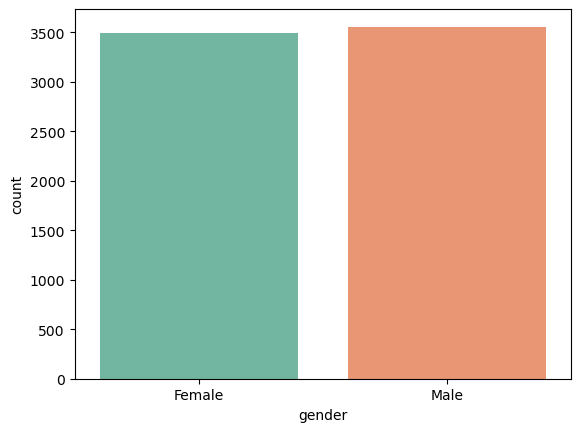

         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328


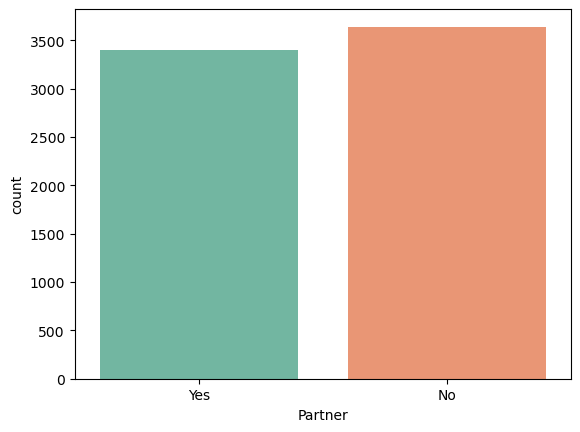

            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824


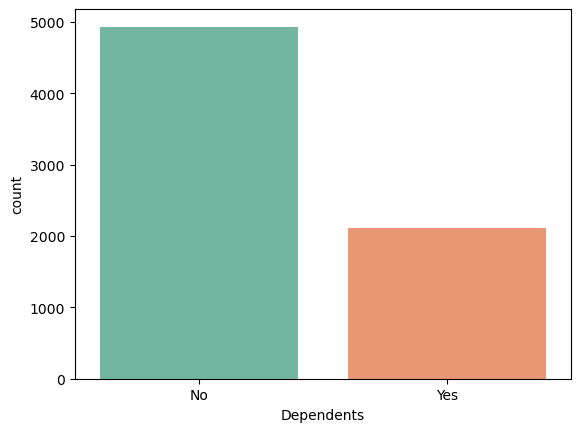

              PhoneService      Ratio
PhoneService                         
Yes                   6361  90.316626
No                     682   9.683374


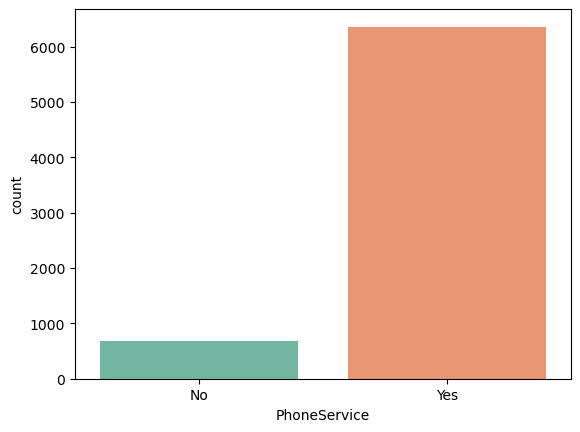

                  PaperlessBilling      Ratio
PaperlessBilling                             
Yes                           4171  59.221922
No                            2872  40.778078


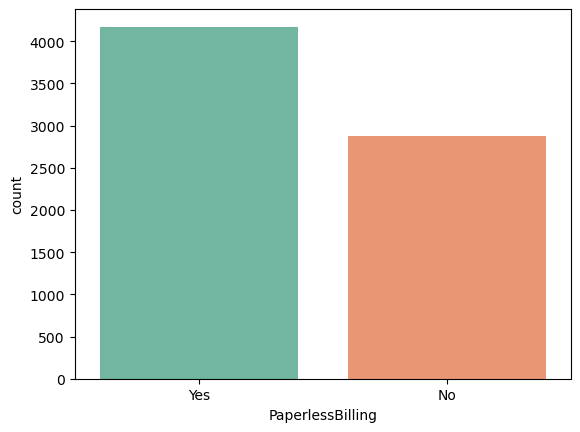

       Churn      Ratio
Churn                  
No      5174  73.463013
Yes     1869  26.536987


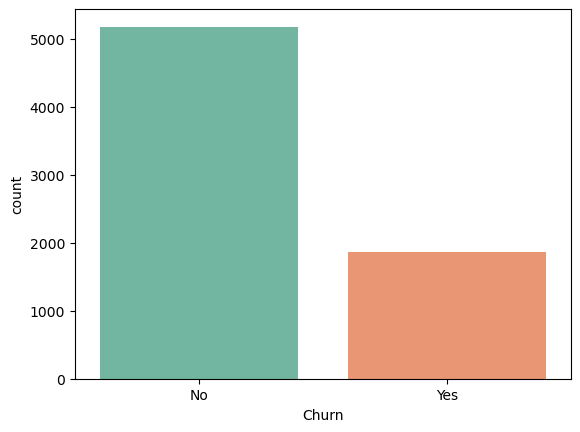

In [13]:
for col in binary_cols:
    cat_summary(Dataset,col,True)

In [15]:
X = Dataset.drop(["Churn","customerID"],axis = 1)
y = Dataset["Churn"]

In [17]:
Encoder = LabelEncoder()
y = Encoder.fit_transform(y)
X[binary_cols[:-1]] = X[binary_cols[:-1]].apply(Encoder.fit_transform)

In [19]:
Features = ["SeniorCitizen","MonthlyCharges","TotalCharges"]
X[Features] = X[Features].apply(pd.to_numeric,errors = 'coerce')

In [21]:
cat_cols = [cols for cols in X.columns if X[cols].dtypes == "object"]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

                  MultipleLines      Ratio
MultipleLines                             
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374


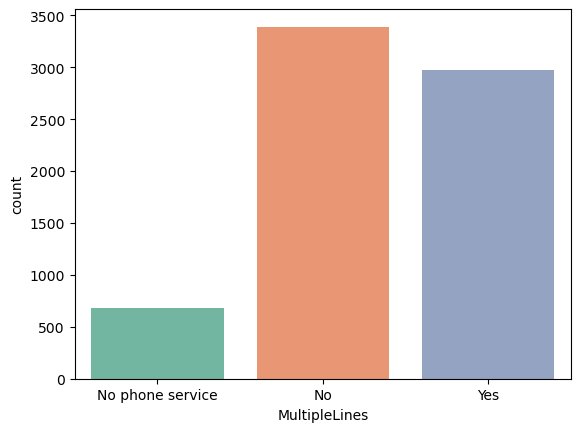

                 InternetService      Ratio
InternetService                            
Fiber optic                 3096  43.958540
DSL                         2421  34.374556
No                          1526  21.666903


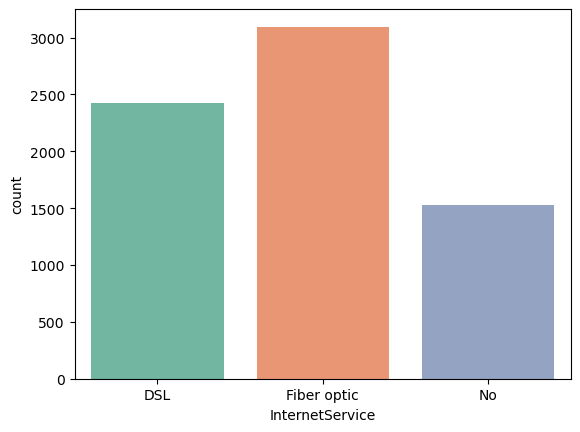

                     OnlineSecurity      Ratio
OnlineSecurity                                
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903


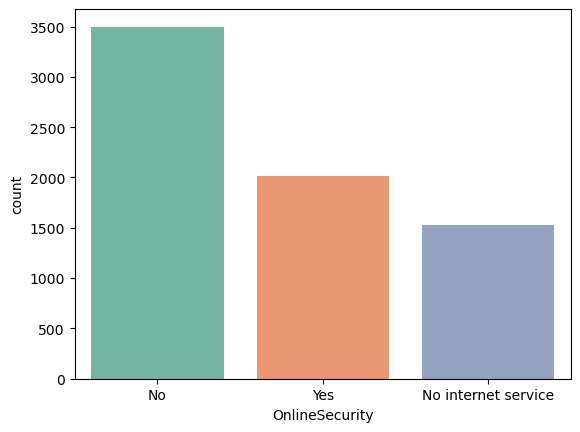

                     OnlineBackup      Ratio
OnlineBackup                                
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903


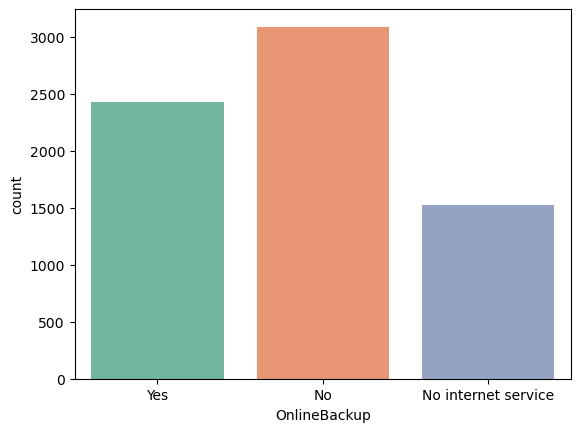

                     DeviceProtection      Ratio
DeviceProtection                                
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903


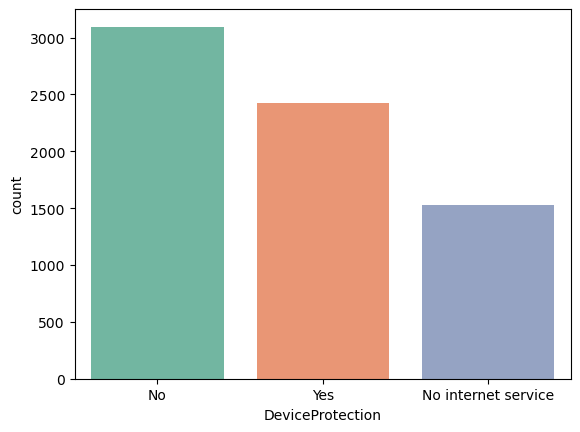

                     TechSupport      Ratio
TechSupport                                
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903


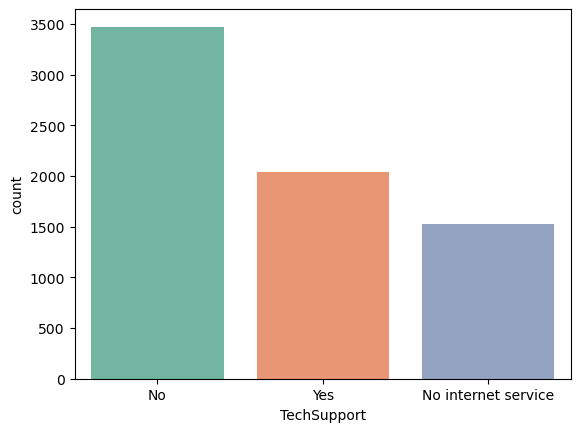

                     StreamingTV      Ratio
StreamingTV                                
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903


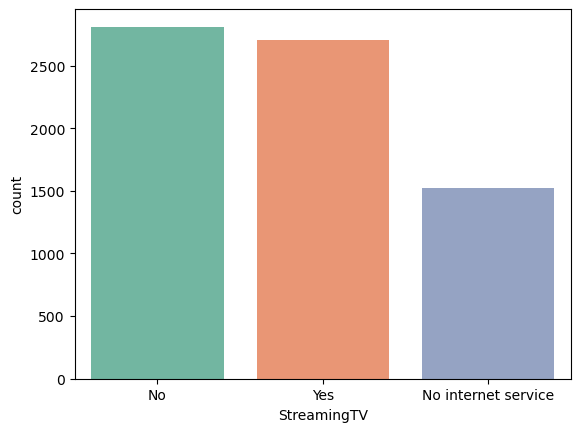

                     StreamingMovies      Ratio
StreamingMovies                                
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903


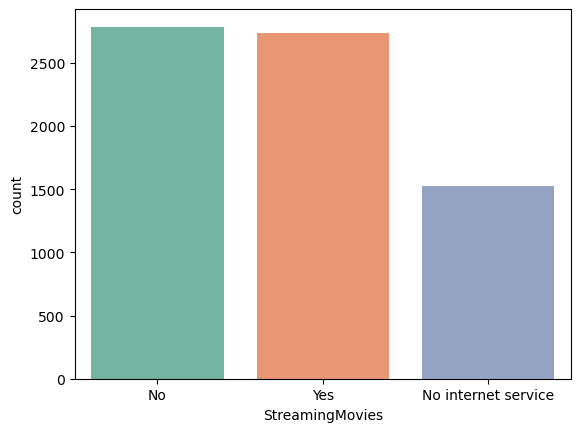

                Contract      Ratio
Contract                           
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383


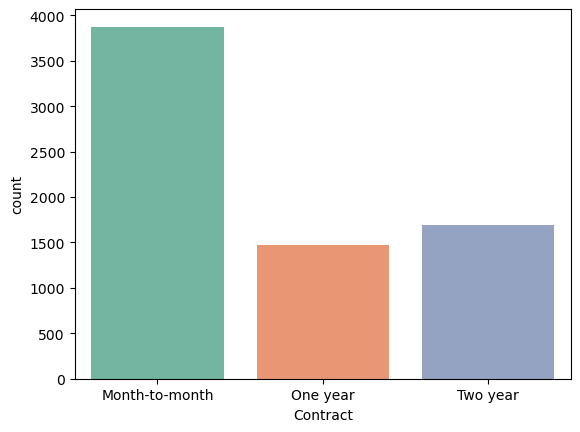

                           PaymentMethod      Ratio
PaymentMethod                                      
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109


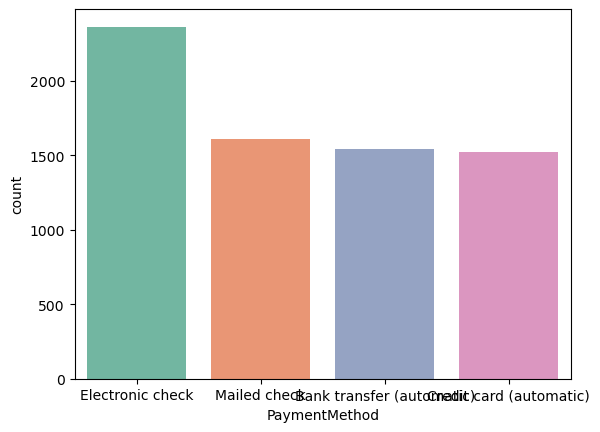

In [23]:
for cols in cat_cols:
    cat_summary(Dataset,cols,True)

In [25]:
numeric_features = [cols for cols in X.columns if cols not in cat_cols]
numeric_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges']

In [27]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        sns.histplot(data=dataframe, x=col_name, bins=20, kde=True, color="blue")
        plt.show(block=True)

count    7043.000000
mean        0.504756
std         0.500013
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         1.000000
60%         1.000000
70%         1.000000
80%         1.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: gender, dtype: float64


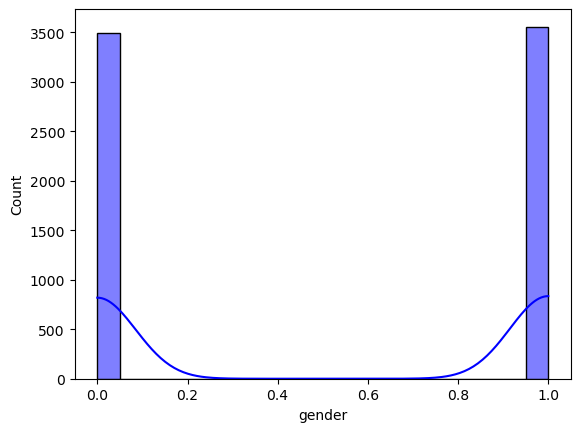

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: SeniorCitizen, dtype: float64


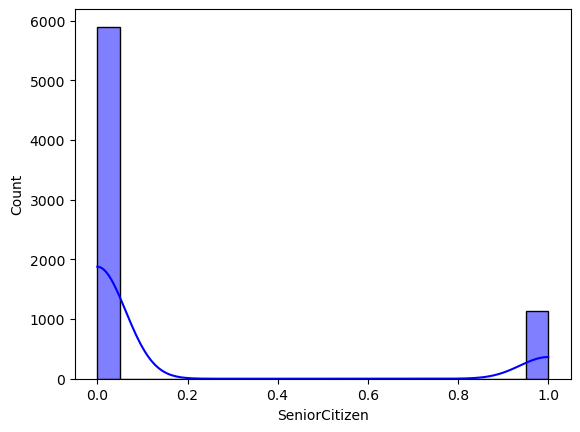

count    7043.000000
mean        0.483033
std         0.499748
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         1.000000
70%         1.000000
80%         1.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: Partner, dtype: float64


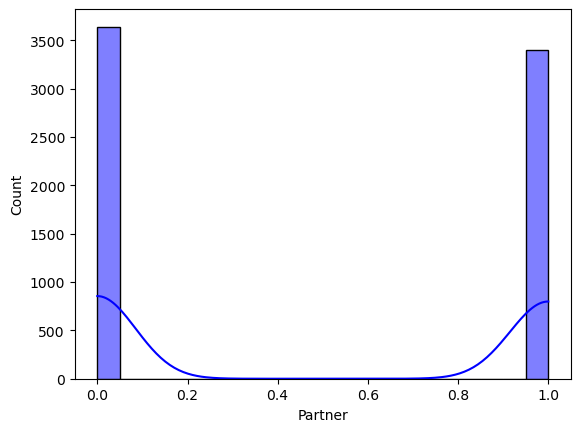

count    7043.000000
mean        0.299588
std         0.458110
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         1.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: Dependents, dtype: float64


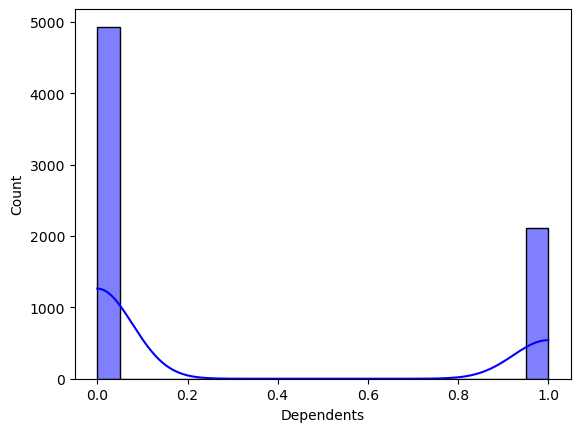

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


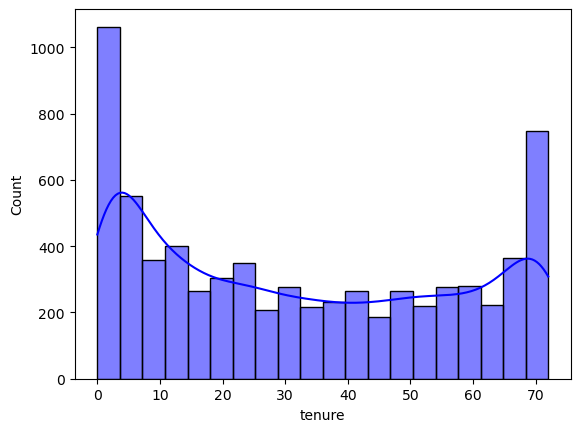

count    7043.000000
mean        0.903166
std         0.295752
min         0.000000
5%          0.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         1.000000
50%         1.000000
60%         1.000000
70%         1.000000
80%         1.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: PhoneService, dtype: float64


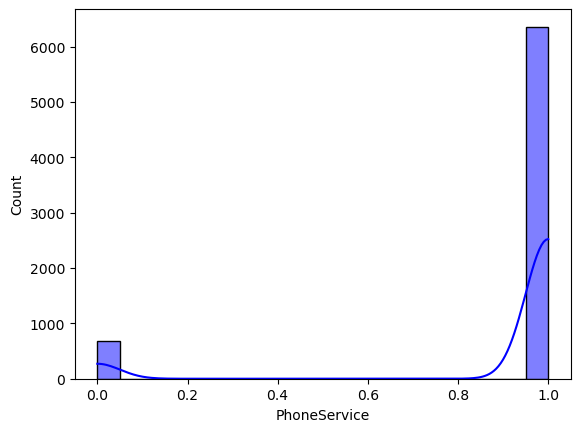

count    7043.000000
mean        0.592219
std         0.491457
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         1.000000
60%         1.000000
70%         1.000000
80%         1.000000
90%         1.000000
95%         1.000000
99%         1.000000
max         1.000000
Name: PaperlessBilling, dtype: float64


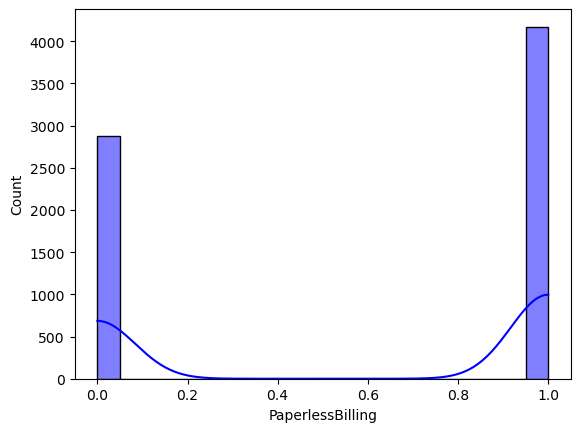

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


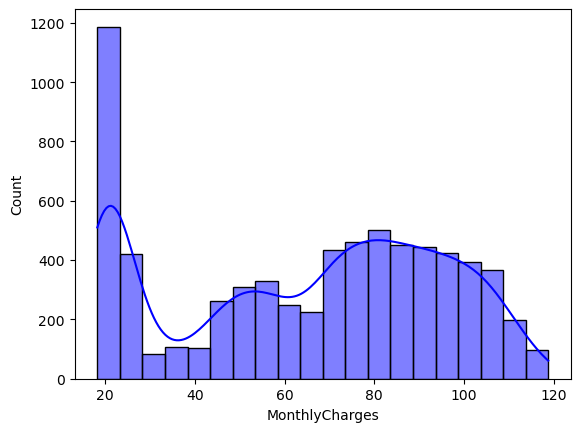

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


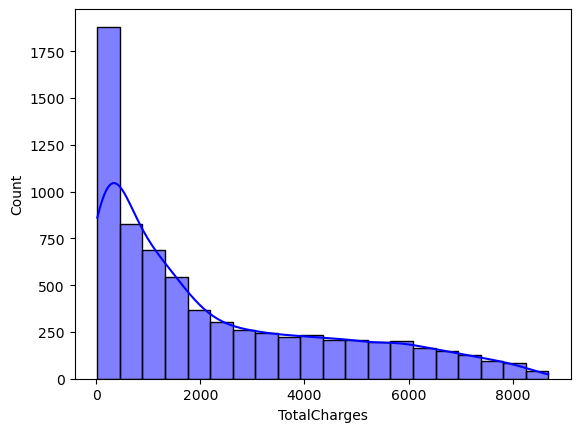

In [29]:
for col in numeric_features:
    num_summary(X, col, plot=True)

# Correlational Analysis

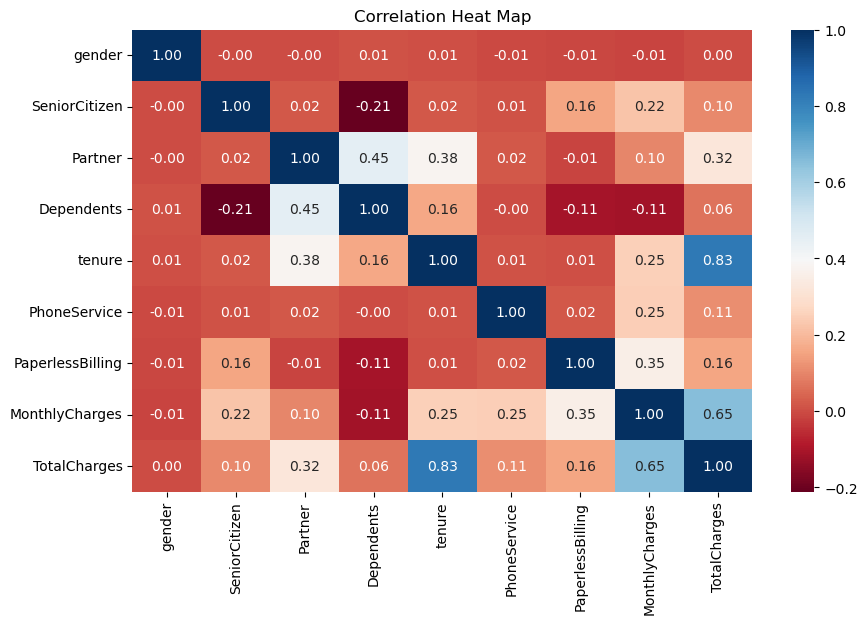

In [32]:
corr = X[numeric_features].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu")
plt.title("Correlation Heat Map")
plt.show()

0
0    5174
1    1869
Name: count, dtype: int64


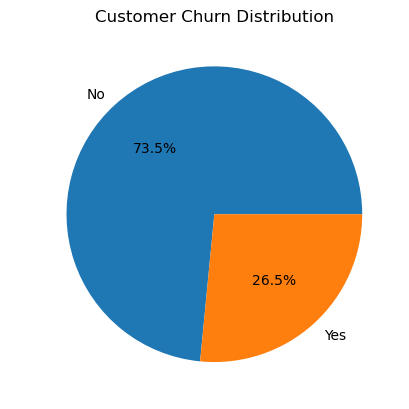

In [34]:
churn_count = pd.DataFrame(y).value_counts()
print(churn_count)
churn_count.plot.pie(
    autopct = '%1.1f%%',
    labels = ["No","Yes"]
)
plt.title("Customer Churn Distribution")
plt.ylabel(" ")
plt.show()

In [36]:
Categorical = X[cat_cols]
df = pd.get_dummies(Categorical)
df.shape

(7043, 31)

In [38]:
X = pd.concat([df,X.drop(Categorical,axis = 1)],axis =1 )
X.shape

(7043, 40)

In [40]:
# Missing Values in 44 column
X.iloc[:,-1] = X.iloc[:,-1].fillna(X.iloc[:,-1].mean())

In [42]:
X.isnull().sum()

MultipleLines_No                           0
MultipleLines_No phone service             0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_No internet service         0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_No internet service           0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProtection_No internet service       0
DeviceProtection_Yes                       0
TechSupport_No                             0
TechSupport_No internet service            0
TechSupport_Yes                            0
StreamingTV_No                             0
StreamingTV_No internet service            0
StreamingTV_Yes                            0
StreamingMovies_No                         0
StreamingM

In [44]:
Scaler = StandardScaler()
X = Scaler.fit_transform(X)

In [46]:
LR = LogisticRegression()
kf = KFold(n_splits = 5,shuffle = True, random_state = 42)
scores = cross_val_score(LR,X,y,cv = kf, scoring = "accuracy")
print("Score for each Fold: ",scores)
print("Average Scores: ",np.mean(scores)*100)

Score for each Fold:  [0.82044003 0.80979418 0.80198722 0.79332386 0.81036932]
Average Scores:  80.71829230918122


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=45
)

In [50]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [52]:
pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [54]:
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test,pred)
f1 = f1_score(y_test, pred)
auc_score = roc_auc_score(y_test, y_proba)

print("Final Model Performance on Test Set")
print("-------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")

Final Model Performance on Test Set
-------------------------------------
Accuracy : 0.7928
Recall   : 0.5481
Precision: 0.6250
F1 Score : 0.5840
AUC      : 0.8347


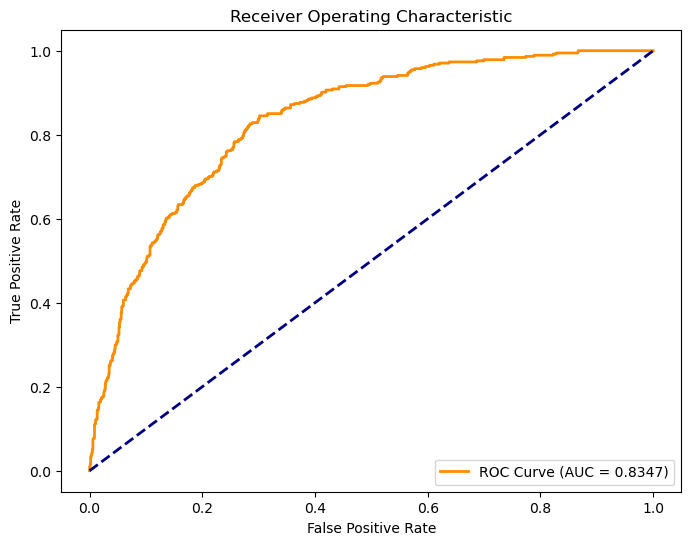

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = calc_auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC Curve (AUC = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

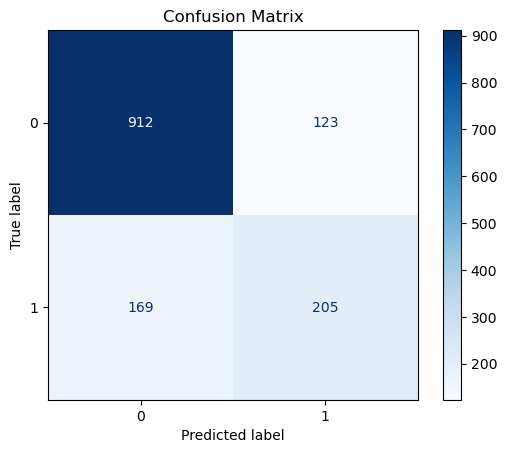

In [58]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()